In [2]:
%matplotlib notebook

In [3]:
import matplotlib.pyplot as plt
import numpy as np

In [107]:
from simple_network_utils import PSTI

In [114]:
x = np.linspace(0., 1., 10000)
sigma = 0.2
extrema_percentile = 0.25

In [115]:
y = np.exp(-((x - 0.5)/sigma)**2.)
# y -= y.min()

power: top_val: 0.91209, bottom_val: 0.06429; std: 0.35370; f_norm_std: bottom: 0.29706, top: 0.05951, total: 0.14105


<IPython.core.display.Javascript object>


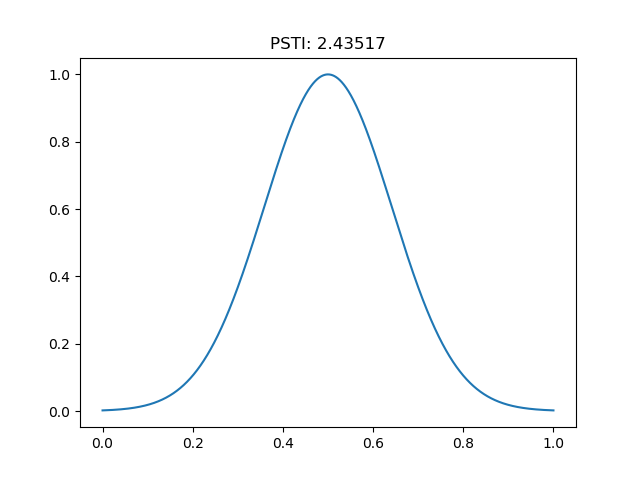

Text(0.5,1,'PSTI: 2.43517')

In [116]:
this_PSTI = PSTI(x, y, extrema_percentile, debug=True)
plt.figure()
plt.plot(x, y)
plt.title('PSTI: %.5f' % this_PSTI)

Help on function std in module numpy.core.fromnumeric:

std(a, axis=None, dtype=None, out=None, ddof=0, keepdims=<no value>)
    Compute the standard deviation along the specified axis.
    
    Returns the standard deviation, a measure of the spread of a distribution,
    of the array elements. The standard deviation is computed for the
    flattened array by default, otherwise over the specified axis.
    
    Parameters
    ----------
    a : array_like
        Calculate the standard deviation of these values.
    axis : None or int or tuple of ints, optional
        Axis or axes along which the standard deviation is computed. The
        default is to compute the standard deviation of the flattened array.
    
        .. versionadded:: 1.7.0
    
        If this is a tuple of ints, a standard deviation is performed over
        multiple axes, instead of a single axis or all the axes as before.
    dtype : dtype, optional
        Type to use in computing the standard deviation. For 

In [ ]:
np.quantile(test, 0.1)

In [ ]:
test[test<0.5] = 1.

In [ ]:
np.mean(test)

In [ ]:
np.quantile(test, (0.1, 0.5))

In [ ]:
np.min(x)

In [ ]:
np.max(x)

In [ ]:
band = (0., 1.)

In [ ]:
np.where((x >= band[0]) & (x <= band[1]))

In [ ]:
type(x)

In [ ]:
type(band[0])